# Прогнозирование оттока клиентов в сети отелей "Как в гостях".

## Введение

### Описание проекта

Заказчик этого исследования — сеть отелей *"Как в гостях"*.

С целью привлечения клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако, если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

### Цель проекта

Разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — **400'000**. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных

В таблицах *hotel_train* и *hotel_test* содержатся одинаковые столбцы:

- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
    - `Contract` — договор с юридическим лицом;
    - `Group` — групповой заезд;
    - `Transient` — не связано с договором или групповым заездом;
    - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
    - `SC` — нет дополнительных опций;
    - `BB` — включён завтрак;
    - `HB` — включён завтрак и обед;
    - `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

## Подготовка данных

Импорт используемых библиотек и методов

In [1]:
# импортируем библиотеки и необходимые методы из других библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

Настройка стилей и форматов вывода

In [2]:
# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# установим графическую тему для графиков и гистограмм
plt.style.use('seaborn')

# настроим отображение до 25-ти колонок
pd.set_option('display.max_columns', 25)

# настроим местоположение и размер шрифта для легенды и названий графиков и гистограмм
rcParams['legend.loc'] = 'upper left'
rcParams['legend.fontsize'] = 14
rcParams['axes.titlesize'] = 16

Объявление глобальных переменных

In [3]:
# случайное состояние для создания псевдослучайных последовательностей
MY_SEED = 1123581321

# бюджет на разработку системы прогнозирования
BUDGET = 400_000

# размер депозита (коэффициент от стоимости и затрат)
DEPOSIT_SIZE = 0.8

# сезонные коэффициенты
SPRING_RATIO = 1.2
SUMMER_RATIO = 1.4
STANDART_RATIO = 1

# стоимость номеров за ночь
PRICE_CLASS_A = 1_000
PRICE_CLASS_B = 800
PRICE_CLASS_C = 600
PRICE_CLASS_D = 550
PRICE_CLASS_E = 500
PRICE_CLASS_F = 450
PRICE_CLASS_G = 350

# стоимость разового обслуживания
SERVICE_CLASS_A = 400
SERVICE_CLASS_B = 350
SERVICE_CLASS_C = 350
SERVICE_CLASS_D = 150
SERVICE_CLASS_E = 150
SERVICE_CLASS_F = 150
SERVICE_CLASS_G = 150

Чтение данных

In [4]:
# читаем данные в датафреймы с локального ПК, а если не получится, то из интернета
try:
    train = pd.read_csv('./datasets/hotel_train.csv', sep=',')
    test = pd.read_csv('./datasets/hotel_test.csv', sep=',')
except:
    print('ОШИБКА: Данные не были прочитаны, читаем из интернета!')
    train = pd.read_csv('***', sep=',')
    test = pd.read_csv('***', sep=',')
# присвоим таблицам имена:
train.name = 'Обучающий датасет'
test.name = 'Тестовый датасет'

## Предобработка и исследовательский анализ данных

Напишем функцию вывода основной информации о датафрейме.

In [5]:
# -----------------------------------------------------------------------------------------
# функция вывода основной информации о датафрейме:
# - общая информация;
# - описание данных;
# - пример данных (5 случайных строк);
# - информация о наличие явных дубликатов данных;
# - размерность датафрейма.
#
# input:  df - датафрейм, по которому выводим информацию
# output: None
# -----------------------------------------------------------------------------------------

def first_look(df):
    print('Название датафрейма:', df.name, '\n')
    display(df.info())
    display(df.describe().T)
    display(df.sample(5))
    print('Количество дубликатов в данных:', df.duplicated().sum())
    print(f'Количество столбцов: {df.shape[1]}, число записей: {df.shape[0]}')
    print('=' * 150, '\n')
    return

Посмотрим на данные наших таблиц.

In [6]:
first_look(train)
first_look(test)

Название датафрейма: Обучающий датасет 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  floa

None

,count,mean,std,min,25%,50%,75%,max
id,"65,229.00","43,544.07","25,614.86",0.00,"19,108.00","40,554.00","67,414.00","84,121.00"
is_canceled,"65,229.00",0.37,0.48,0.00,0.00,0.00,1.00,1.00
lead_time,"65,229.00",96.34,96.13,0.00,17.00,64.00,151.00,374.00
arrival_date_year,"65,229.00","2,015.72",0.45,"2,015.00","2,015.00","2,016.00","2,016.00","2,016.00"
arrival_date_week_number,"65,229.00",31.34,13.46,1.00,21.00,34.00,42.00,53.00
arrival_date_day_of_month,"65,229.00",15.85,8.75,1.00,8.00,16.00,23.00,31.00
stays_in_weekend_nights,"65,229.00",0.83,0.85,0.00,0.00,1.00,2.00,4.00
stays_in_week_nights,"65,229.00",2.22,1.35,0.00,1.00,2.00,3.00,6.00
adults,"65,229.00",1.84,0.48,0.00,2.00,2.00,2.00,4.00
children,"65,229.00",0.07,0.33,0.00,0.00,0.00,0.00,3.00


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
48874,67367,0,66.00,2016,March,14,31,1,3,2.00,0.00,0.00,BB,BEL,Direct,0,0,0,A,0,0,Transient,0,0,4
15859,18642,0,22.00,2016,November,47,15,2,5,2.00,0.00,0.00,HB,GBR,TA/TO,0,0,0,D,0,0,Transient,0,1,7
835,844,0,83.00,2015,August,36,31,1,1,1.00,0.00,0.00,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,2
9711,12197,0,5.00,2016,January,4,20,0,1,1.00,0.00,0.00,BB,ESP,TA/TO,0,0,0,A,1,0,Transient,0,1,1
63448,82153,0,215.00,2016,November,48,21,1,1,1.00,0.00,0.00,BB,PRT,Corporate,0,0,0,A,1,0,Transient,0,1,2


Количество дубликатов в данных: 0
Количество столбцов: 25, число записей: 65229

Название датафрейма: Тестовый датасет 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        3

None

,count,mean,std,min,25%,50%,75%,max
id,"32,412.00","60,131.51","29,953.59","6,086.00","45,291.75","53,394.50","89,800.25","97,903.00"
is_canceled,"32,412.00",0.39,0.49,0.00,0.00,0.00,1.00,1.00
lead_time,"32,412.00",97.59,86.51,0.00,23.00,76.00,155.00,373.00
arrival_date_year,"32,412.00","2,017.00",0.00,"2,017.00","2,017.00","2,017.00","2,017.00","2,017.00"
arrival_date_week_number,"32,412.00",17.80,9.18,1.00,10.00,18.00,25.00,35.00
arrival_date_day_of_month,"32,412.00",15.66,8.77,1.00,8.00,15.50,23.00,31.00
stays_in_weekend_nights,"32,412.00",0.87,0.85,0.00,0.00,1.00,2.00,4.00
stays_in_week_nights,"32,412.00",2.34,1.38,0.00,1.00,2.00,3.00,6.00
adults,"32,412.00",1.86,0.49,0.00,2.00,2.00,2.00,4.00
children,"32,412.00",0.08,0.34,0.00,0.00,0.00,0.00,3.00


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
19315,84807,0,16.00,2017,January,3,19,1,3,2.00,0.00,0.00,SC,NOR,TA/TO,0,0,0,A,0,0,Transient,0,1,4
23061,88553,0,99.00,2017,March,13,28,0,4,2.00,0.00,0.00,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3103,20018,0,0.00,2017,January,4,23,1,0,2.00,0.00,0.00,BB,PRT,Direct,0,0,0,A,0,0,Transient,1,0,1
19519,85011,0,16.00,2017,January,4,25,0,4,2.00,0.00,0.00,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4
12202,49391,1,179.00,2017,April,17,27,1,3,2.00,0.00,0.00,BB,HKG,TA/TO,0,0,0,D,0,0,Transient,0,3,4


Количество дубликатов в данных: 0
Количество столбцов: 25, число записей: 32412



Тренировочные и тестовые данные имеют одинаковое количество и названия колонок. Названия столбцов корректные, пропусков и явных дубликатов в данных нет.
Столбец `id` не содержит полезной информации, удалим его.
Колонки `lead_time`, `adults`, `children` и  `babies` содержат целочисленные значения, а имеют вещественный тип `float64`. Приведём эти столбцы в соответствие их типам.
Целевым признаком является столбец `is_canceled`.

In [7]:
# удалим лишний столбец
train.drop(['id'], axis='columns', inplace=True)
test.drop(['id'], axis='columns', inplace=True)

# приведем столбцы вещественного типа к целочисленному
lst = list(train.select_dtypes('float64').columns)
train[lst] = train[lst].astype('int64')
test[lst] = test[lst].astype('int64')

После удаление столбца возможно появление дубликатов данных, проверим ещё раз.

In [8]:
print('Количество дубликатов в обучающем датафрейме:', train.duplicated().sum())
print('Количество дубликатов в тестовом датафрейме:', test.duplicated().sum())

Количество дубликатов в обучающем датафрейме: 21377
Количество дубликатов в тестовом датафрейме: 7717


Обнаружилось огромное количество дубликатов в обоих датасетах. Точную причину их появления в нашем случае выяснить не получится. Это могут быть как технические причины, так и человеческий фактор. Часть дубликатов возможно появилась в связи с групповым бронированием номеров во время каких-нибудь мероприятий. В любом случае, для построения моделей такие записи будут мешать, особенно, при использовании кросс-валидации. Удалим эти записи.

In [9]:
# удалим из обучающей выборки явные дубликаты данных
train.drop_duplicates(inplace=True)

Рассмотрим тепловую карту корреляции признаков.

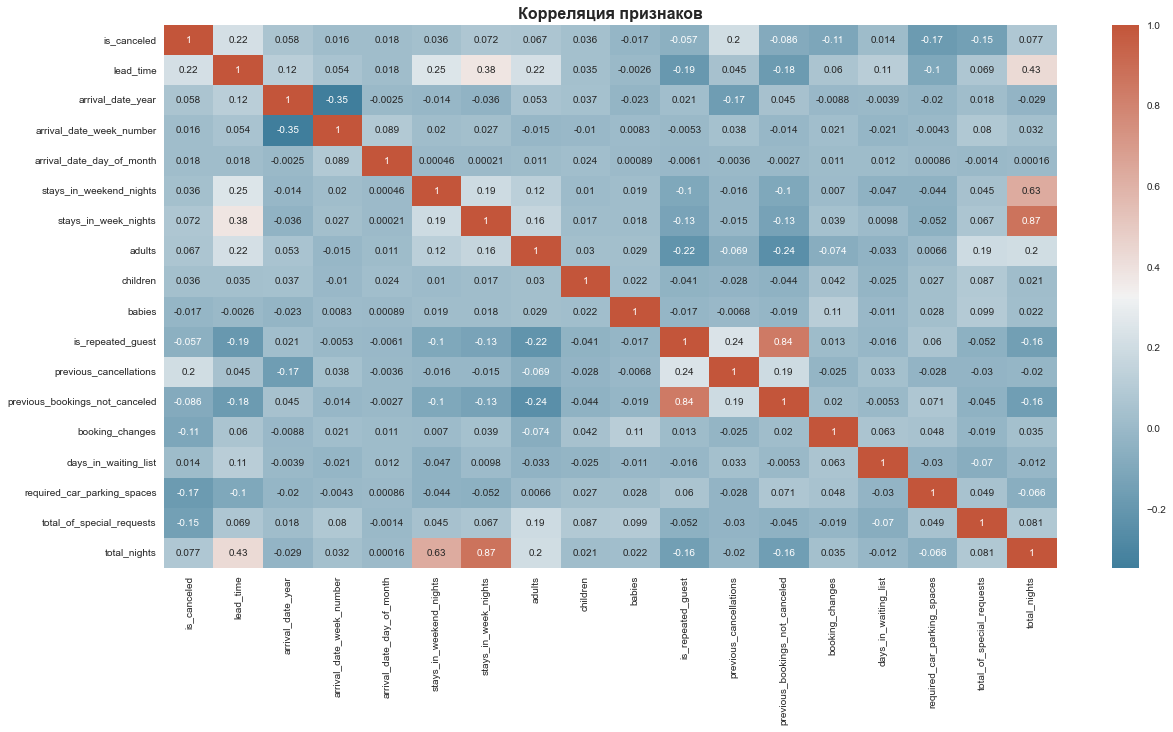

In [10]:
plt.figure(figsize=(20, 10))
plt.title('Корреляция признаков', weight = 'bold')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

Прослеживается явная зависимость между количеством подтверждённых заказов и повторным бронированием. Кроме того, в наших данных есть коллинеарные признаки - `total_nights`, `stays_in_week_nights` и `stays_in_weekend_nights`. Проверим эту теорию.

In [11]:
print('Количество записей, в которых сумма ночей в будние дни и выходные не совпадает:',
      len(train.loc[train['total_nights'] != train['stays_in_week_nights'] + train['stays_in_weekend_nights']]))

Количество записей, в которых сумма ночей в будние дни и выходные не совпадает: 0


Удалим из данных столбец `total_nights`, так как он является суммой количества ночей в выходные и будние дни.

In [12]:
train.drop(['total_nights'], axis='columns', inplace=True)
test.drop(['total_nights'], axis='columns', inplace=True)

### Изучение категориальных признаков

Рассмотрим столбцы `adults`, `children`, `babies`. Несмотря на то, что в описании к данным присутствует слово *"количество"* это категориальные данные.

In [13]:
display(train['adults'].value_counts().to_frame())
display(train['children'].value_counts().to_frame())
display(train['babies'].value_counts().to_frame())

,adults
2,32299
1,8688
3,2688
0,164
4,13


,children
0,40471
1,2060
2,1305
3,16


,babies
0,43403
1,444
2,3
10,1
9,1


В столбце `babies` таблицы `train` содержатся явные ошибочные значения (выбросы), проверим, есть ли такие данные в таблице `test`.

In [14]:
display(test['babies'].value_counts().to_frame())

,babies
0,32237
1,171
2,4


Как видим, нет таких значений. Удалим строки с количеством детей больше 8.

In [15]:
train = train.loc[train['babies'] < 9]

Проверим, есть ли записи, в которых бронирование осуществлялось без взрослых, без детей и без младенцев.

In [16]:
display(train.loc[(train['adults'] == 0) & (train['babies'] == 0) & (train['children'] == 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
23770,0,48,2016,February,9,21,2,4,0,0,0,SC,CHE,Direct,0,0,0,B,2,0,Transient-Party,0,0
26878,0,122,2016,May,19,5,2,4,0,0,0,SC,PRT,TA/TO,0,0,0,E,3,0,Transient,0,0
26879,0,122,2016,May,19,5,2,4,0,0,0,SC,CHE,TA/TO,0,0,0,E,3,0,Transient,0,0
31570,0,256,2016,August,35,21,3,5,0,0,0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,0
41461,0,0,2015,November,49,30,1,2,0,0,0,SC,PRT,Corporate,1,0,1,A,2,0,Transient,0,0
50744,0,52,2016,April,18,30,2,4,0,0,0,SC,SWE,Direct,0,0,0,E,2,0,Transient-Party,0,1
54881,0,108,2016,July,28,5,2,5,0,0,0,SC,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0
56674,0,4,2016,August,32,5,2,2,0,0,0,SC,RUS,TA/TO,0,0,0,A,2,0,Transient,0,2
57390,0,88,2016,August,34,16,0,4,0,0,0,BB,PRT,TA/TO,0,0,0,D,5,0,Transient,0,2
58416,0,36,2016,August,35,27,3,6,0,0,0,SC,ESP,TA/TO,0,0,0,A,2,0,Transient,0,2


Удалим записи об этих странных постояльцах, которые не являются взрослыми, детьми и даже младенцами.

In [17]:
train = train.loc[~((train['adults'] == 0) & (train['babies'] == 0) & (train['children'] == 0))]

Кроме того, у нас есть записи, в которых количество взрослых 0, если в таких записях есть младенцы, надо тоже исключить такие строки, потому что младенцев без взрослых в отель не заселят и это явная ошибка. Проверим наши данные на такое совпадение.

In [18]:
display(train.loc[(train['adults'] == 0) & (train['babies'] > 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
22534,0,6,2015,December,51,18,0,1,0,2,1,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,2
44049,1,22,2015,December,50,9,1,4,0,2,1,BB,PRT,Direct,0,0,0,B,1,0,Transient,0,1
52923,0,14,2016,June,24,9,0,3,0,2,1,BB,ITA,TA/TO,0,0,0,B,2,0,Transient,0,2


Избавимся от этих аномалий. Проверим, не удалили ли лишнее.

In [19]:
train = train.loc[~((train['adults'] == 0) & (train['babies'] > 0))]
print('Количество записей в train:', len(train))

Количество записей в train: 43832


Всё верно, в датафрейме `train` было удалено 2 записи с аномально большим количеством младенцев, 15 записей с нулевым значением взрослых, детей и младенцев, а так же три записи, где постояльцами должны были быть младенцы без взрослых. В таблице `test` записи не удалялись, потому что эти данные для окончательного тестирования качества модели.

Так как младенцев равное 2 в обоих таблицах крайне мало, сделаем из этого столбца признак наличия младенцев. То есть младенцы или есть или их нет вообще. Для этого приравняем количество младенцев равное двум к единице и для корректности переименуем этот столбец в `has_babies`.

In [20]:
train.loc[train['babies'] == 2, 'babies'] = 1
train.rename(columns={'babies': 'has_babies'}, inplace=True)
test.loc[test['babies'] == 2, 'babies'] = 1
test.rename(columns={'babies': 'has_babies'}, inplace=True)

Рассмотрим столбец `country`.

In [21]:
display(train['country'].value_counts().to_frame())
display(test['country'].value_counts().to_frame())
print(train['country'].unique().tolist())

,country
PRT,14458
FRA,4824
GBR,4273
ESP,3907
DEU,2754
...,...
NIC,1
BEN,1
MAC,1
VGB,1


,country
PRT,9887
GBR,3927
FRA,3477
DEU,2378
ESP,1932
...,...
CIV,1
GNB,1
ATA,1
ASM,1


['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL', 'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA', 'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT', 'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA', 'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB', 'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA', 'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS', 'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR', 'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE', 'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP', 'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ', 'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD', 'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA', 'GAB', 'MKD', 'TMP', 'GLP', 'KEN', 'LIE', 'MMR', 'PAN', 'BFA', 'LBY', 'GNB', 'MLI', 'BHR', 'NAM', 'BOL', 'SYC', 'PRY',

В данных содержится большое количество стран с небольшим количеством значений. Так как они имеют малозначимое влияние при моделировании, соберём такие страны под одним именем `other`, а в качестве критерия будем использовать частоту уникальных значений меньше 0.1%. Кроме того, отметим различное количество уникальных значений в обучающей и тестовой таблицах. Чтобы избежать ошибок при моделировании, для кодирования категориальных признаков применим метод *OHE (One-Hot Encoding)* из библиотеки *"scikit-learn"*.

In [22]:
vc = train['country'].value_counts(normalize=True)
train.loc[train['country'].isin(vc[vc < 0.001].index), 'country'] = 'other'
vc = test['country'].value_counts(normalize=True)
test.loc[test['country'].isin(vc[vc < 0.001].index), 'country'] = 'other'

Исследуем колонку `customer_type`.

In [23]:
display(train['customer_type'].value_counts().to_frame())
display(test['customer_type'].value_counts().to_frame())
print(train['customer_type'].unique().tolist())

,customer_type
Transient,35353
Transient-Party,6346
Contract,1874
Group,259


,customer_type
Transient,27461
Transient-Party,4427
Contract,359
Group,165


['Transient', 'Contract', 'Transient-Party', 'Group']


С этими данными порядок, аномалий не наблюдается.

Рассмотрим столбец `distribution_channel`.

In [24]:
display(train['distribution_channel'].value_counts().to_frame())
display(test['distribution_channel'].value_counts().to_frame())
print(train['distribution_channel'].unique().tolist())

,distribution_channel
TA/TO,35171
Direct,5818
Corporate,2753
GDS,90


,distribution_channel
TA/TO,27083
Direct,3642
Corporate,1602
GDS,85


['Direct', 'TA/TO', 'Corporate', 'GDS']


Данным не требуется какая-либо корректировка.

Исследуем колонку `meal`.

In [25]:
display(train['meal'].value_counts().to_frame())
display(test['meal'].value_counts().to_frame())
print(train['meal'].unique().tolist())

,meal
BB,35544
SC,4656
HB,3344
SC,153
FB,135


,meal
BB,24684
SC,5035
HB,2399
SC,258
FB,36


['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC']


Категории имеют немного различное распределение в выборках, это нормально, а вот пробелы в названиях лучше убрать.

In [26]:
train['meal'] = train['meal'].str.strip()
test['meal'] = test['meal'].str.strip()

Рассмотрим столбец `reserved_room_type`.

In [27]:
display(train['reserved_room_type'].value_counts().to_frame())
display(test['reserved_room_type'].value_counts().to_frame())
print(train['reserved_room_type'].unique().tolist())

,reserved_room_type
A,30434
D,8421
E,2251
F,1178
B,741
G,580
C,227


,reserved_room_type
A,23471
D,6123
E,1644
F,503
G,278
C,201
B,192


['A               ', 'C               ', 'D               ', 'E               ', 'G               ', 'F               ', 'B               ']


Также наблюдаются лишние пробелы в названиях, уберём их.

In [28]:
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
test['reserved_room_type'] = test['reserved_room_type'].str.strip()

Исследуем колонку `arrival_date_year`.

In [29]:
display(train['arrival_date_year'].value_counts().to_frame())
display(test['arrival_date_year'].value_counts().to_frame())

,arrival_date_year
2016,33992
2015,9840


,arrival_date_year
2017,32412


Годы идут вперёд, вернуться не получится, а значит в будущих моделях год нам не поможет. Удалим этот столбец.

In [30]:
train.drop(['arrival_date_year'], axis='columns', inplace=True)
test.drop(['arrival_date_year'], axis='columns', inplace=True)

Рассмотрим столбец `arrival_date_month`.

In [31]:
display(train['arrival_date_month'].value_counts().to_frame())
display(test['arrival_date_month'].value_counts().to_frame())

,arrival_date_month
October,5513
September,5212
August,4721
December,4132
November,4094
July,4015
March,3247
April,3218
May,3084
June,2827


,arrival_date_month
May,5262
April,4878
June,4580
March,4277
July,3626
February,3543
January,3150
August,3096


Необходимо отметить, что тестовый датасет представлен первыми 8-ю месяцами.

Исследуем колонку `arrival_date_week_number`.

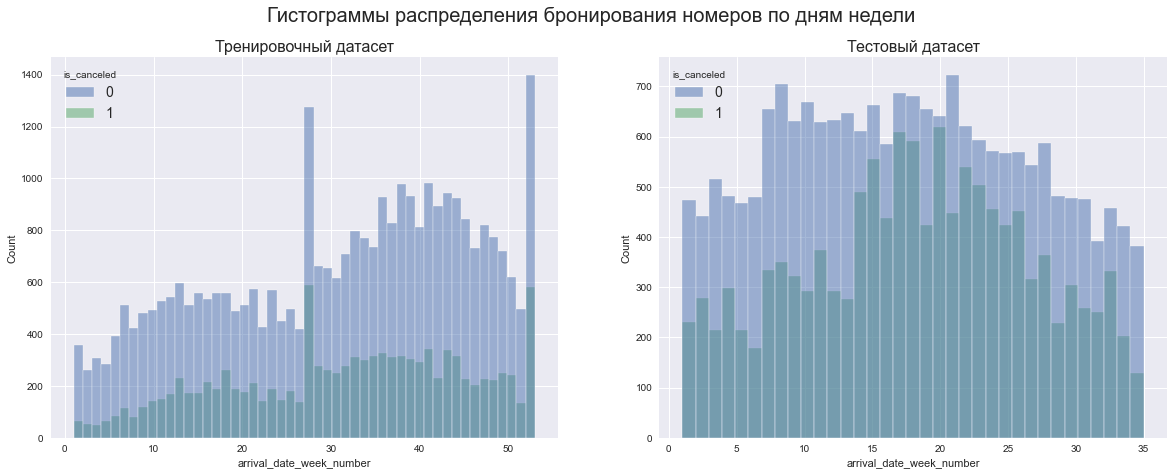

In [32]:
# вывод гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Гистограммы распределения бронирования номеров по дням недели', fontsize=20)
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.histplot(data=train, x='arrival_date_week_number', bins=50, hue='is_canceled', ax=axes[0])
sns.histplot(data=test, x='arrival_date_week_number', bins=35, hue='is_canceled', ax=axes[1])
plt.show()

В обучающем датафрейме можно наблюдать повышенный интерес к некоторым неделям.

Рассмотрим столбец `arrival_date_day_of_month`.

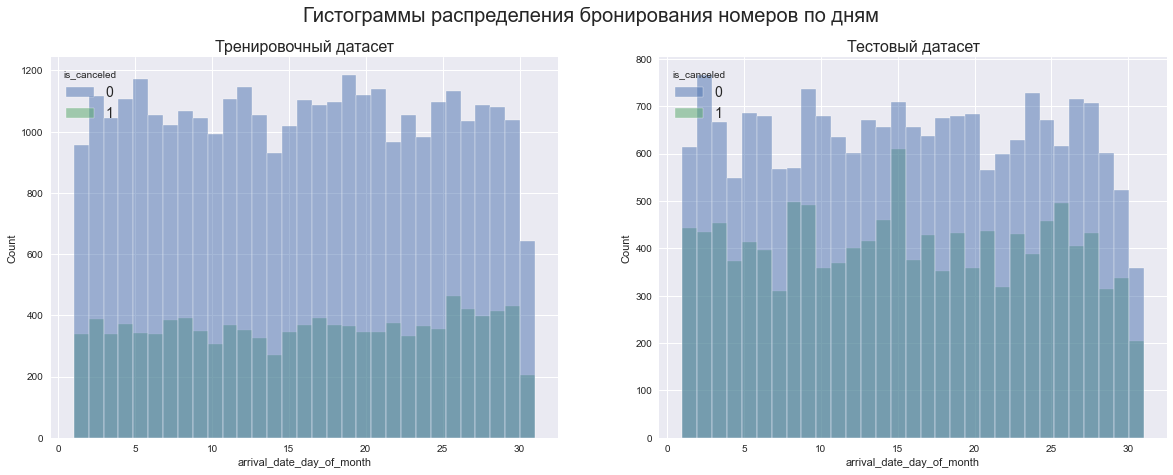

In [33]:
# вывод гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Гистограммы распределения бронирования номеров по дням', fontsize=20)
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.histplot(data=train, x='arrival_date_day_of_month', bins=31, hue='is_canceled', ax=axes[0])
sns.histplot(data=test, x='arrival_date_day_of_month', bins=31, hue='is_canceled', ax=axes[1])
plt.show()

Небольшое количество бронирований 31-го числа связано с тем, что не каждый месяц в году содержит 31 день.

Исследуем колонку `is_repeated_guest` (признак того, что гость бронирует номер второй раз). Это бинарный категориальный признак. Выведем для него гистограммы распределения и посмотрим сколько из повторных бронирований было отменено.

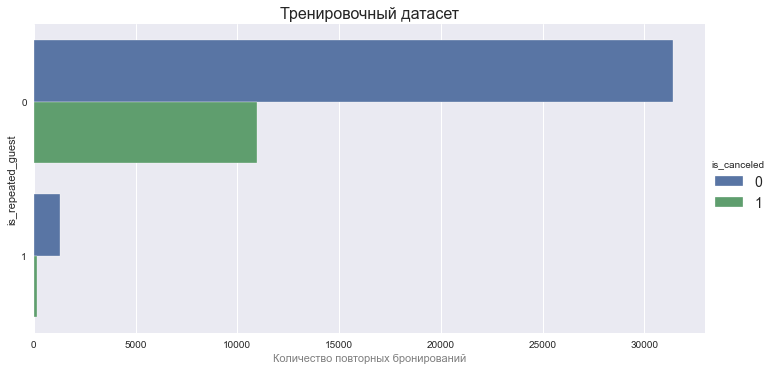

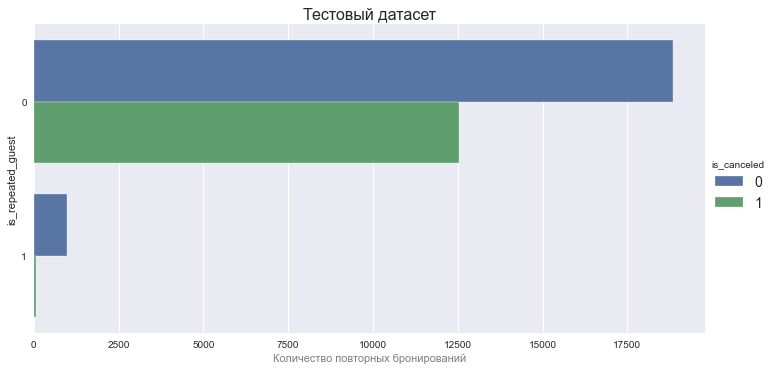

In [34]:
# вывод гистограммы распределения
sns.catplot(data=train, y='is_repeated_guest', hue='is_canceled', kind='count', height=5, aspect=2).set(title='Тренировочный датасет')
plt.xlabel('Количество повторных бронирований', color='grey')
sns.catplot(data=test, y='is_repeated_guest', hue='is_canceled', kind='count', height=5, aspect=2).set(title='Тестовый датасет')
plt.xlabel('Количество повторных бронирований', color='grey')
plt.show()

Как видим, повторных бронирований было крайне мало, но даже среди них были отмены брони. Нельзя считать тех, кто бронировал номер повторно очень надёжными клиентами.

Рассмотрим столбец `required_car_parking_spaces`.

In [35]:
display(train['required_car_parking_spaces'].value_counts().to_frame())
display(test['required_car_parking_spaces'].value_counts().to_frame())

,required_car_parking_spaces
0,40234
1,3586
2,11
3,1


,required_car_parking_spaces
0,30935
1,1468
2,6
8,2
3,1


Как и в случае с младенцами наблюдаем небольшое количество случаев, когда есть необходимость бронирования мест для автомобилей больше одного. Перестроим эту колонку в признаковую и переименуем ее в `is_required_car_parking_spaces`.

In [36]:
train.loc[train['required_car_parking_spaces'] > 1, 'required_car_parking_spaces'] = 1
train.rename(columns={'required_car_parking_spaces': 'is_required_car_parking_spaces'}, inplace=True)
test.loc[test['required_car_parking_spaces'] == 2, 'required_car_parking_spaces'] = 1
test.rename(columns={'required_car_parking_spaces': 'is_required_car_parking_spaces'}, inplace=True)

Соберём названия всех категориальных столбцов в один список и проверим эти данные.

In [37]:
cat_columns_lst = ['adults', 'has_babies', 'children', 'country', 'customer_type', 'distribution_channel', 'meal',
                   'reserved_room_type', 'is_repeated_guest', 'arrival_date_month', 'arrival_date_week_number',
                   'arrival_date_day_of_month', 'is_required_car_parking_spaces']

display(train[cat_columns_lst].sample(5))

,adults,has_babies,children,country,customer_type,distribution_channel,meal,reserved_room_type,is_repeated_guest,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,is_required_car_parking_spaces
54641,2,0,0,PRT,Transient,TA/TO,SC,A,0,July,28,7,0
64327,2,0,0,FRA,Transient,Direct,BB,A,0,December,50,9,0
7486,2,0,0,IRL,Contract,TA/TO,BB,A,0,September,37,8,0
61699,2,0,0,ROU,Transient,TA/TO,BB,D,0,October,43,20,0
41164,1,0,0,PRT,Transient-Party,TA/TO,BB,A,0,October,42,15,0


Все категориальные колонки обработаны, удалены аномальные данные, лишние пробелы, создан список названий всех категориальных признаков, данные готовы к кодированию и дальнейшему использованию в моделировании.

### Исследование количественных признаков

Напишем функцию, которая будет отображать плотность распределения и ящик с усами для каждого количественного признака.

In [38]:
# -----------------------------------------------------------------------------------------
# функция вывода информации для количественных значений:
# - плотность распределения;
# - boxplot.
#
# input:    df - датафрейм, по которому выводим информацию;
#           col_title - название признака;
#           num_bins - количество корзин для гистограммы.
# output:   None
# -----------------------------------------------------------------------------------------

def show_num_features(df, col_title, num_bins):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title(col_title + '. Плотность распределения', fontsize=16)
    axes[0].set_ylabel('плотность')
    axes[1].set_title(col_title + '. Ящик с усами', fontsize=16)
    axes[1].set_ylabel('значения')
    sns.histplot(df, bins=num_bins, ax=axes[0])
    sns.boxplot(data=df, ax=axes[1])
    plt.show()
    return

Создадим список столбцов с количественным признаком и в цикле с помощью функции `show_num_features` выведем для каждого гистограмму распределения плотности значений и ящик с усами. Сначала для обучающего датафрейма:

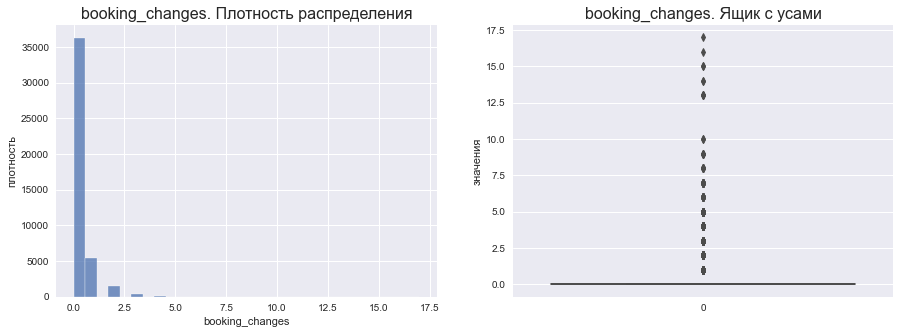

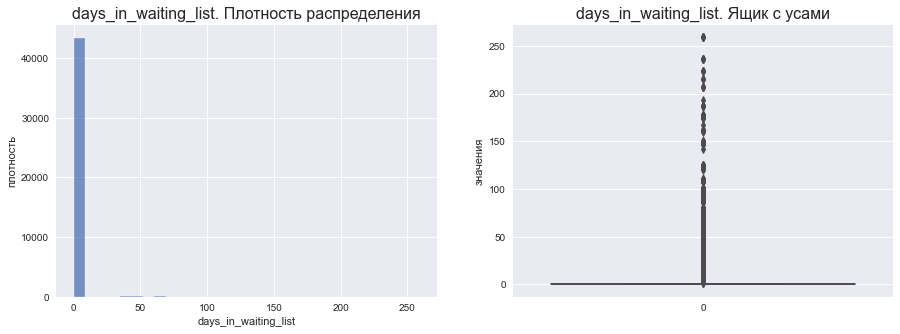

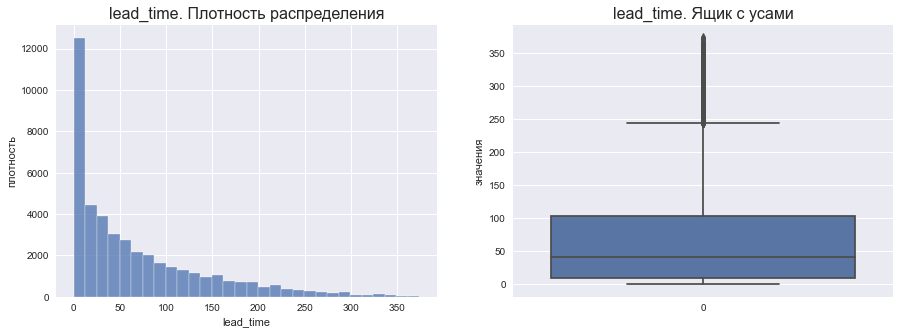

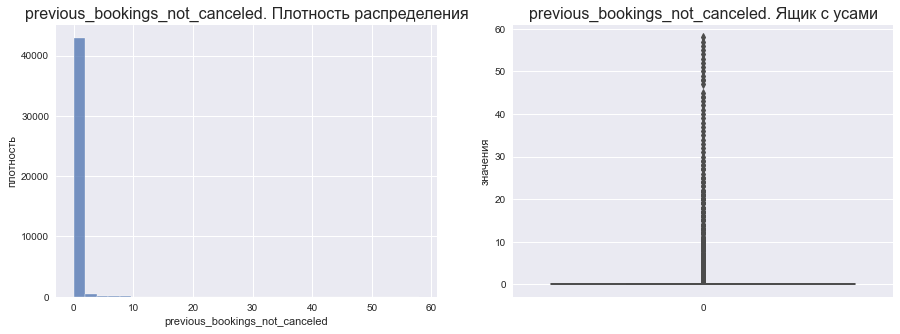

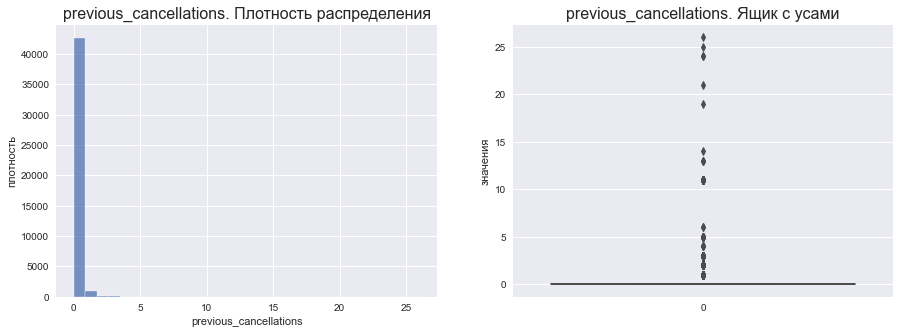

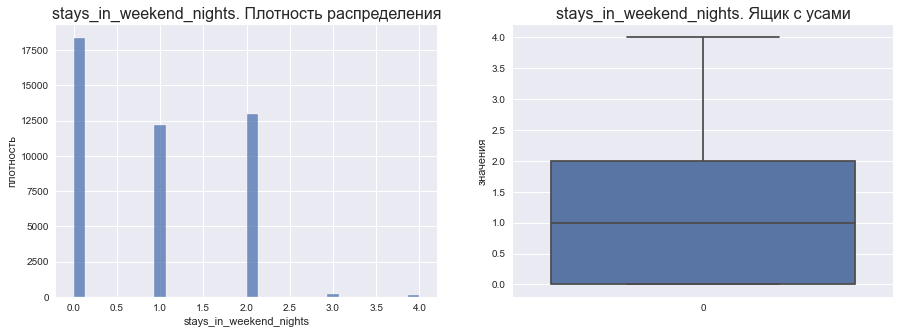

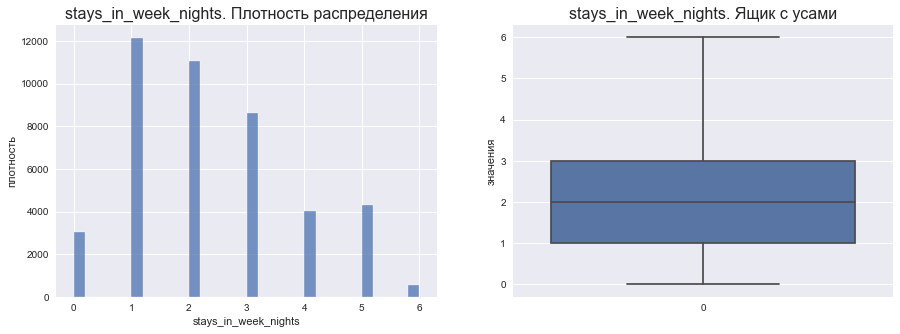

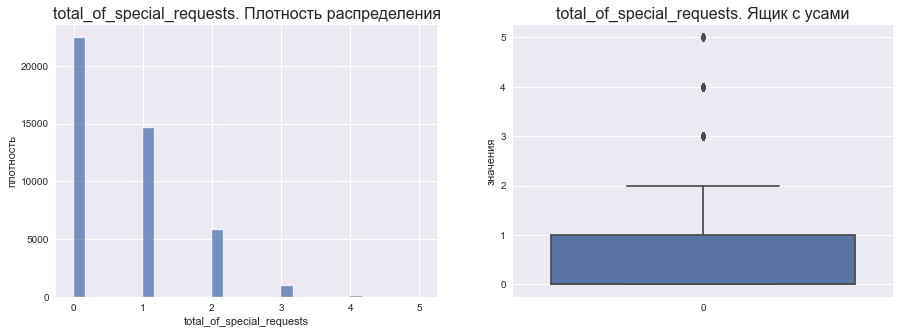

In [39]:
num_columns_lst = ['booking_changes', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']

for column in train[num_columns_lst]:
    show_num_features(train[column], column, num_bins=30)

Столбцы `booking_changes`, `days_in_waiting_list`, `previous_bookings_not_canceled` и `previous_cancellations` содержат малое количество значений больше 1, переделаем их в признаковые и переименуем соответственно в `is_booking_changes`, `is_in_waiting_list`, `is_previous_bookings_not_canceled` и `is_previous_cancellations`. Добавим их в список категориальных колонок `cat_columns_lst` и удалим из списка названий количественных признаков `num_columns_lst`.

In [40]:
col_lst = ['booking_changes', 'days_in_waiting_list', 'previous_bookings_not_canceled', 'previous_cancellations']
ren_lst = ['is_booking_changes', 'is_in_waiting_list', 'is_previous_bookings_not_canceled', 'is_previous_cancellations']

for column in col_lst:
    train.loc[train[column] > 1, column] = 1
    test.loc[test[column] > 1, column] = 1

renaming_dict = dict(zip(col_lst, ren_lst))

train.rename(columns=renaming_dict, inplace=True)
test.rename(columns=renaming_dict, inplace=True)

for index in range(len(col_lst)):
    num_columns_lst.remove(col_lst[index])

cat_columns_lst = cat_columns_lst + ren_lst

Рассмотрим попарные связи количественных признаков наших данных, выделим цветом отмену бронирования.

<Figure size 1080x1080 with 0 Axes>

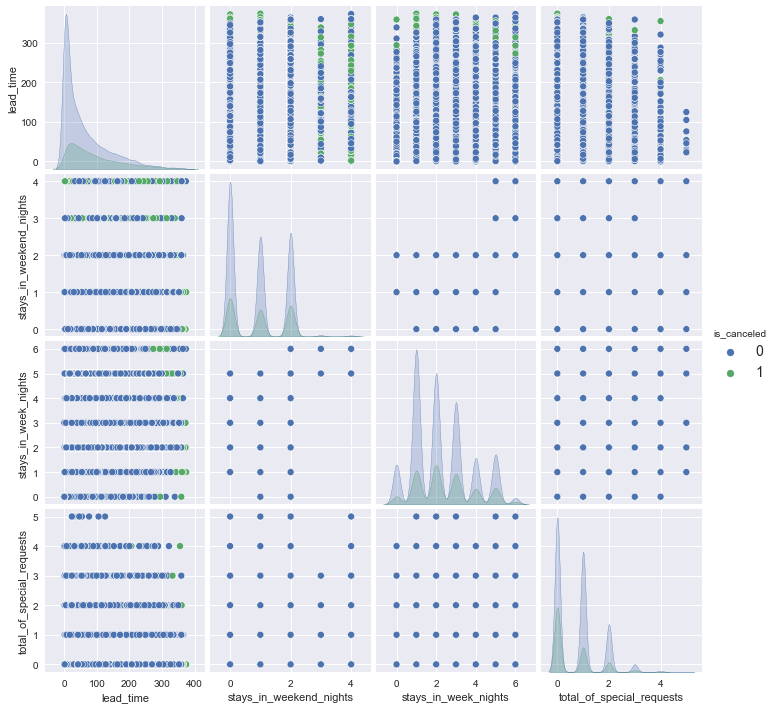

In [41]:
plt.figure(figsize=(15, 15))
sns.pairplot(train[num_columns_lst + ['is_canceled']], hue='is_canceled')
plt.show()

Здесь необходимо отметить, что клиенты, у которых ранее уже было больше 10 отказов, вероятнее всего отменят бронирование. Также чем раньше происходит бронирование, тем больше вероятность, что в процессе ожидания бронь будет отменена.

Все признаки рассмотрены, лишние данные удалены, выделен целевой признак, составлены списки категориальных и количественных признаков. Данные готовы для дальнейших расчётов и построения моделей.

### Исследование целевого признака

Изучим целевой признак, столбец `is_canceled`.

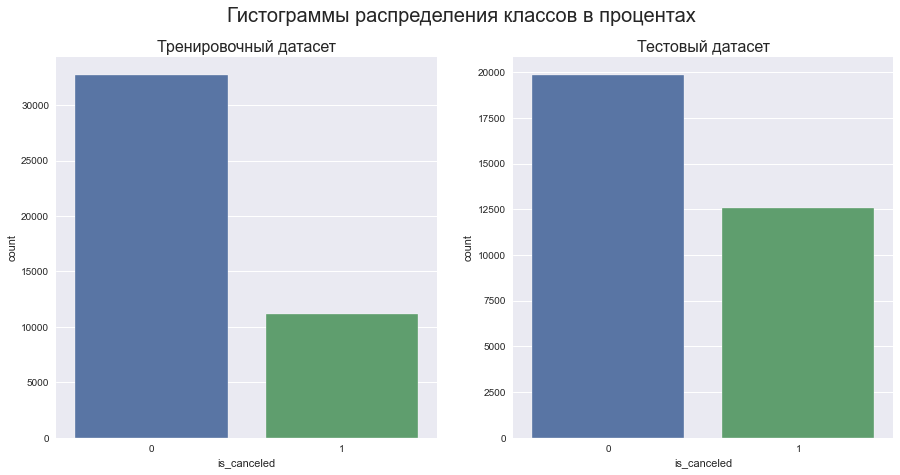

Тренировочный датасет, класс 0: 74.57%, класс 1: 25.43%
Тестовый датасет, класс 0:      61.15%, класс 1: 38.85%


In [42]:
# вывод гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Гистограммы распределения классов в процентах', fontsize=20)
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.countplot(data=train, x='is_canceled', ax=axes[0])
sns.countplot(data=test, x='is_canceled', ax=axes[1])
plt.show()

# вывод распределения классов в процентах
print(f"Тренировочный датасет, класс 0: {1 - train['is_canceled'].mean():.2%}, класс 1: {train['is_canceled'].mean():.2%}")
print(f"Тестовый датасет, класс 0:      {1 - test['is_canceled'].mean():.2%}, класс 1: {test['is_canceled'].mean():.2%}")

Видно, что выборки не стратифицированные, но расхождение не велико. Кроме того, имеется явный дисбаланс классов - более $\frac{1}{3}$ клиентов отказавшихся от брони и приблизительно $\frac{2}{3}$ клиентов, которые воспользовались бронированием. При моделировании необходимо это учитывать и применять методы балансировки классов.

### Вычисление бизнес-метрики

Оценим прибыль отеля без внедрения депозитов.
Напишем функцию `season_ratio`, которая рассчитает сезонный коэффициент, 20% для осени, 40% летом и для остальных сезонов он равен 1.

In [43]:
# -----------------------------------------------------------------------------------------
# функция расчёта сезонного коэффициента
#
# input:    months - столбец с месяцами
# output:   season_rates - объект Series с сезонными коэффициентами
# -----------------------------------------------------------------------------------------

def season_ratio(months):

    season_rates = months.copy()

    # присвоим летний коэффициент
    season_rates.loc[(months == 'June') | (months == 'July') | (months == 'August')] = SPRING_RATIO

    # присвоим осенний коэффициент
    season_rates.loc[(months == 'September') | (months == 'October') | (months == 'November')] = SUMMER_RATIO

    # присвоим стандартный коэффициент
    season_rates.loc[(months == 'December') | (months == 'January') | (months == 'February') |
                     (months == 'March') | (months == 'April') | (months == 'May')] = STANDART_RATIO

    return season_rates

Также напишем функцию `price_service_room` для расчёта стоимости номера и стоимости разового обслуживания.

In [44]:
# -----------------------------------------------------------------------------------------
# функция расчёта стоимости номера и стоимости разового обслуживания
# в зависимости от типа номера
#
# input:    room_type - столбец с типом забронированной комнаты
# output:   prices - объект Series со стоимостью номера за ночь
#           services - объект Series со стоимостью разового обслуживания
# -----------------------------------------------------------------------------------------

def price_service_room(room_type):

    prices = room_type.copy()
    services = room_type.copy()

    # присвоим стоимость номера
    prices.loc[room_type == 'A'] = PRICE_CLASS_A
    prices.loc[room_type == 'B'] = PRICE_CLASS_B
    prices.loc[room_type == 'C'] = PRICE_CLASS_C
    prices.loc[room_type == 'D'] = PRICE_CLASS_D
    prices.loc[room_type == 'E'] = PRICE_CLASS_E
    prices.loc[room_type == 'F'] = PRICE_CLASS_F
    prices.loc[room_type == 'G'] = PRICE_CLASS_G

    # присвоим стоимость разового обслуживания
    services.loc[room_type == 'A'] = SERVICE_CLASS_A
    services.loc[room_type == 'B'] = SERVICE_CLASS_B
    services.loc[room_type == 'C'] = SERVICE_CLASS_C
    services.loc[room_type == 'D'] = SERVICE_CLASS_D
    services.loc[room_type == 'E'] = SERVICE_CLASS_E
    services.loc[room_type == 'F'] = SERVICE_CLASS_F
    services.loc[room_type == 'G'] = SERVICE_CLASS_G

    return prices, services

Рассчитаем для тестового датасета сезонные коэффициенты, стоимость номера и стоимость разового обслуживания. Кроме того, просуммируем и сохраним количество проведённых ночей в будние и выходные дни, такая колонка ранее была в данных, но она была удалена, теперь для упрощения расчётов нам понадобятся эти значения.

In [45]:
season_rates = season_ratio(test['arrival_date_month'])
room_price, services = price_service_room(test['reserved_room_type'])
total_nights = test['stays_in_week_nights'] + test['stays_in_weekend_nights']

Рассчитаем прибыль отеля или убыток, в случае отмены бронирования. Так как уборка производится каждые два дня, разделим пополам и округлим в *большую* сторону количество ночей. Важный момент - стандартные функции округления *Python* нам не подойдут, так как используют *"банковское округление"* и при округлении 0.5 мы получим 0. Поэтому, воспользуемся функцией `ceil()` из библиотеки `numpy`.

In [46]:
profit = test['arrival_date_month'].copy()
profit.loc[test['is_canceled'] == 0] = room_price * season_rates * total_nights - services * np.ceil(total_nights / 2)
profit.loc[test['is_canceled'] == 1] = - (room_price * season_rates + services)

Вычислим прибыль и убытки отеля за тестовый период без учёта внедрения безвозвратных депозитов.

In [47]:
print(f"Прибыль сети отелей за тестовый период:       {profit.sum():,} руб.")
print(f"Убытки за тестовый период, при отмене брони: {profit.loc[test['is_canceled'] == 1].sum():,} руб.")
print(f"Убытки составляют {profit.loc[test['is_canceled'] == 1].sum() / profit.sum():.2%} от прибыли.")

Прибыль сети отелей за тестовый период:       28,723,530.0 руб.
Убытки за тестовый период, при отмене брони: -16,211,440.0 руб.
Убытки составляют -56.44% от прибыли.


Сеть отелей несёт просто колоссальные убытки от клиентов, которые отказываются от заранее забронированных номеров - более **56%** от полученной прибыли. Заранее предсказанный такой клиент принесёт существенную экономию. Прибыль за тестовый период составила **28 млн. 723 тыс. рублей**.

## Разработка модели ML

Подготовим данные и набор параметров для моделей.

In [48]:
# создадим признаки для моделей
features_train = train.drop('is_canceled', axis=1)
features_test = test.drop('is_canceled', axis=1)

# выделим целевой признак
target_train = train['is_canceled']
target_test = test['is_canceled']

# зададим диапазоны гиперпараметров для подбора
param_distributions = {'RFC__n_estimators': range(50, 325, 25),
                       'RFC__max_depth': range(1, 18, 1),
                       'RFC__min_samples_split': range(2, 52, 5),
                       'RFC__min_samples_leaf': range(2, 52, 5)}

# подготовим кросс-валидацию на 3-х выборках
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=MY_SEED)

Для обучения выберем метрику *recall (полнота)*, потому что эта метрика показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Для снижения затрат нам как раз важно найти наибольшее количество тех, кто отменит бронирование и предложить им внести депозит.

Обучим модели с использованием различных методов масштабирования, кодирования категориальных признаков и баланасировки классов.

### *StandardScaler + OHE + SMOTE + Random Forest*

In [49]:
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(StandardScaler()), num_columns_lst),
    ('cat', make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore')), cat_columns_lst)]))
# балансировка классов (TPP - target pre-processing)
step_TPP = ('TPP', SMOTE(random_state=MY_SEED))
# классификатор модели
step_RFC = ('RFC', RandomForestClassifier(random_state=MY_SEED))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[step_FPP, step_TPP, step_RFC])

# создадим объект модели
rs_imba = RandomizedSearchCV(pipeline_RFC, param_distributions, n_iter=150, cv=kf, verbose=1,
                             n_jobs=-1, scoring='recall', return_train_score=True, random_state=MY_SEED)

# зафитим модель и замерим время моделирования
start_time = time.time()
rs_imba.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'recall = {rs_imba.best_score_:.4f}')

# создадим датафрейм с результатами тестирования
df_results = pd.DataFrame({'Модель': ['StandardScaler + OHE + SMOTE + Random Forest'], 'recall': [rs_imba.best_score_],
                           'Время обучения (минуты)': [run_time], 'Гиперпараметры': [rs_imba.best_params_]})

Fitting 3 folds for each of 150 candidates, totalling 450 fits
recall = 0.8029


### *MinMaxScaler + OHE + Near Miss + Random Forest*

In [50]:
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(MinMaxScaler()), num_columns_lst),
    ('cat', make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore')), cat_columns_lst)]))
# балансировка классов (TPP - target pre-processing)
step_TPP = ('TPP', NearMiss())
# классификатор модели
step_RFC = ('RFC', RandomForestClassifier(random_state=MY_SEED))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[step_FPP, step_TPP, step_RFC])

# создадим объект модели
rs_imba = RandomizedSearchCV(pipeline_RFC, param_distributions, n_iter=150, cv=kf, verbose=1,
                             n_jobs=-1, scoring='recall', return_train_score=True, random_state=MY_SEED)

# зафитим модель и замерим время моделирования
start_time = time.time()
rs_imba.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'recall = {rs_imba.best_score_:.4f}')

# добавим результаты тестирования в датасет
df_results.loc[len(df_results.index)] = ['MinMaxScaler + OHE+ Near Miss + Random Forest',
                                         rs_imba.best_score_, run_time, rs_imba.best_params_]

Fitting 3 folds for each of 150 candidates, totalling 450 fits
recall = 0.7213


### *MinMaxScaler + OrdinalEncoder + SMOTE + Gradient Boosting*

In [51]:
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(MinMaxScaler()), num_columns_lst),
    ('cat', make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), cat_columns_lst)]))
# балансировка классов (TPP - target pre-processing)
step_TPP = ('TPP', SMOTE(random_state=MY_SEED))
# классификатор модели
step_RFC = ('RFC', GradientBoostingClassifier(random_state=MY_SEED))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[step_FPP, step_TPP, step_RFC])

# создадим объект модели
rs_imba = RandomizedSearchCV(pipeline_RFC, param_distributions, n_iter=150, cv=kf, verbose=1,
                             n_jobs=-1, scoring='recall', return_train_score=True, random_state=MY_SEED)

# зафитим модель и замерим время моделирования
start_time = time.time()
rs_imba.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'recall = {rs_imba.best_score_:.4f}')

# добавим результаты тестирования в датасет
df_results.loc[len(df_results.index)] = ['MinMaxScaler + OrdinalEncoder + SMOTE + Gradient Boosting',
                                         rs_imba.best_score_, run_time, rs_imba.best_params_]

Fitting 3 folds for each of 150 candidates, totalling 450 fits
recall = 0.6736


### *MinMaxScaler + OrdinalEncoder + Random Forest*

Рассмотрим ещё одну модель, основной идеей в которой будет метод балансировки класса, выполненный в самом классификаторе *RandomForest*, с помощью параметра `class_weight='balanced'`.

In [52]:
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(MinMaxScaler()), num_columns_lst),
    ('cat', make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), cat_columns_lst)]))
# классификатор модели
step_RFC = ('RFC', RandomForestClassifier(random_state=MY_SEED, class_weight='balanced'))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[step_FPP, step_RFC])

# создадим объект модели
rs_imba = RandomizedSearchCV(pipeline_RFC, param_distributions, n_iter=150, cv=kf, verbose=1,
                             n_jobs=-1, scoring='recall', return_train_score=True, random_state=MY_SEED)

# зафитим модель и замерим время моделирования
start_time = time.time()
rs_imba.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'recall = {rs_imba.best_score_:.4f}')

# создадим датафрейм с результатами тестирования
df_results.loc[len(df_results.index)] = ['MinMaxScaler + OrdinalEncoder + Random Forest',
                                         rs_imba.best_score_, run_time, rs_imba.best_params_]

Fitting 3 folds for each of 150 candidates, totalling 450 fits
recall = 0.7896


Сравним полученные результаты и выберем наиболее подходящую нам модель.

In [53]:
# выведем датафрейм с полученными результатами
pd.set_option('display.float_format', '{:,.4f}'.format)
display(df_results)

,Модель,recall,Время обучения (минуты),Гиперпараметры
0,StandardScaler + OHE + SMOTE + Random Forest,0.8029,33.3782,"{'RFC__n_estimators': 75, 'RFC__min_samples_sp..."
1,MinMaxScaler + OHE+ Near Miss + Random Forest,0.7213,14.8659,"{'RFC__n_estimators': 50, 'RFC__min_samples_sp..."
2,MinMaxScaler + OrdinalEncoder + SMOTE + Gradie...,0.6736,93.0311,"{'RFC__n_estimators': 50, 'RFC__min_samples_sp..."
3,MinMaxScaler + OrdinalEncoder + Random Forest,0.7896,8.1439,"{'RFC__n_estimators': 50, 'RFC__min_samples_sp..."


Лучшие показатели метрики *recall* получились у модели *StandardScaler + OHE + SMOTE + Random Forest*, однако время обучения такой модели более получаса. При этом метрика *recall* модели *MinMaxScaler + OrdinalEncoder + Random Forest* с балансировкой классов внутри классификатора самой модели не сильно меньше, но время обучения всего *8 минут*. Для предсказания на тестовых данных будем использовать именно эту модель. Проверим ёё на тестовой выборке. Изучим метрики модели, проверим её на адекватность.

In [54]:
# получим предсказание модели на тестовой выборке
predicted_test = rs_imba.best_estimator_.predict(features_test)

# получим оценки вероятности положительного исхода
rf_probs = rs_imba.best_estimator_.predict_proba(features_test)[:, 1]

Выведем метрики полученной модели и оптимальные гиперпараметры.

In [55]:
# выведем значение F1-меры и значение ROC-AUC для положительного исхода
print(f'F1-мера  = {f1_score(target_test, predicted_test):.4f}')
print(f'ROC-AUC  = {roc_auc_score(target_test, rf_probs):.4f}')
print(f'Accuracy = {accuracy_score(target_test, predicted_test):.4f}')
print(f'Recall   = {recall_score(target_test, predicted_test):.4f}')

# выведем значения гиперпараметров модели
display(rs_imba.best_params_)

F1-мера  = 0.6576
ROC-AUC  = 0.8075
Accuracy = 0.6893
Recall   = 0.7680


{'RFC__n_estimators': 50,
 'RFC__min_samples_split': 47,
 'RFC__min_samples_leaf': 32,
 'RFC__max_depth': 3}

Построим ROC-кривую.

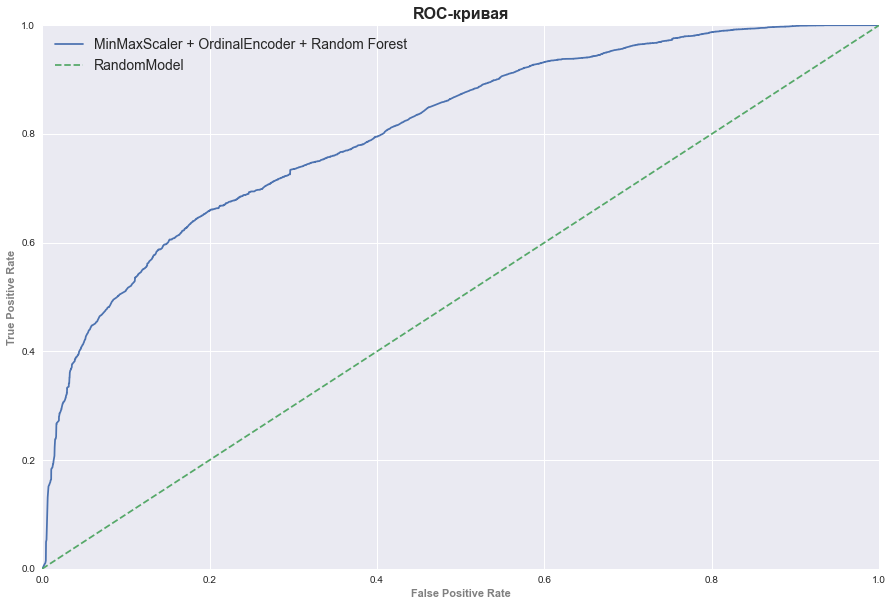

In [56]:
# выведем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, rf_probs)
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label='MinMaxScaler + OrdinalEncoder + Random Forest')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

# установим границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', color='grey', weight = 'bold')
plt.ylabel('True Positive Rate', color='grey', weight = 'bold')
plt.title('ROC-кривая', weight = 'bold')
plt.legend()
plt.show()

Проверим модель на адекватность. Создадим *baseline* модель с помощью *Dummy-классификатора*. Рассчитаем для этой модели метрику `recall` и сравним её с нашей моделью.

In [57]:
# создадим baseline модель с помощью Dummy-классификатора
dc = DummyClassifier(strategy='stratified', random_state=MY_SEED)
dc.fit(features_train, target_train)
dc_pred = dc.predict(features_test)
dc_recall = recall_score(target_test, dc_pred)

# выведем результаты моделирования
print(f'Полнота для модели Dummy-классификатора на тестовой выборке: {dc_recall:.4f}')

Полнота для модели Dummy-классификатора на тестовой выборке: 0.2565


### Выводы по качеству полученной модели

В результате исследований мы получили модель с хорошими показателями метрик. Модель значительно лучше предсказывает, чем при использовании случайного предсказания. Доля правильных ответов нашей модели **0.7680**, что значительно выше, чем у baseline модели (0.2565).


## Прибыль от внедрения модели

Прибыль от использования нашей модели сеть отелей получит в том случае, когда реально произошла отмена бронирования, но модель предсказала такой случай и клиент внёс депозит в размере 80% от стоимости номера и затрат на уборку. Таким образом, прибыль от использования модели будет равна 80% от убытков, предсказанных отмен бронирования. Иными словами, если была отмена бронирования и модель её предсказала, то модель в этом случае сэкономит 80% , так как был внесён депозит.
Так как тестовый период в нашем случае 8 месяцев, то для получения годовых показателей надо умножить полученные данные на 12:8 или на 1.5, таким образом вычислим потенциальные убытки и прибыли за год.

In [58]:
profit_pred = abs((profit.loc[(test['is_canceled'] == 1) & (predicted_test == 1)] * DEPOSIT_SIZE).sum())

print(f'Прибыль сети отелей от внедрения модели за тестовый период: {profit_pred:,} руб.')
print(f'Годовая прибыль сети отелей от внедрения модели           : {profit_pred * 1.5:,} руб.')

Прибыль сети отелей от внедрения модели за тестовый период: 10,071,344.0 руб.
Годовая прибыль сети отелей от внедрения модели           : 15,107,016.0 руб.


Оценим модель с учётом затрат на разработку.

In [59]:
if (profit_pred - BUDGET) > 0:
    print(f'Модель окупилась за тестовый период, прибыль с учётом затрат на разработку составила: {profit_pred - BUDGET:,} руб.')
    print(f'Годовая прибыль от внедрения модели c учётом затрат не разработку составит          : {profit_pred * 1.5 - BUDGET:,} руб.')
else:
    print(f'Модель не окупилась за тестовый период, убыток с учётом затрат на разработку составил: {profit_pred - BUDGET:,} руб.')

Модель окупилась за тестовый период, прибыль с учётом затрат на разработку составила: 9,671,344.0 руб.
Годовая прибыль от внедрения модели c учётом затрат не разработку составит          : 14,707,016.0 руб.


Внедрение модели, которая предсказывает отмену бронирования окупит себя уже в 1-й месяц её использования, а за год принесёт прибыль более *14.7 миллионов рублей*.

## Признаки "ненадёжного" клиента

Выведем 15 наиболее значимых признаков нашей модели.

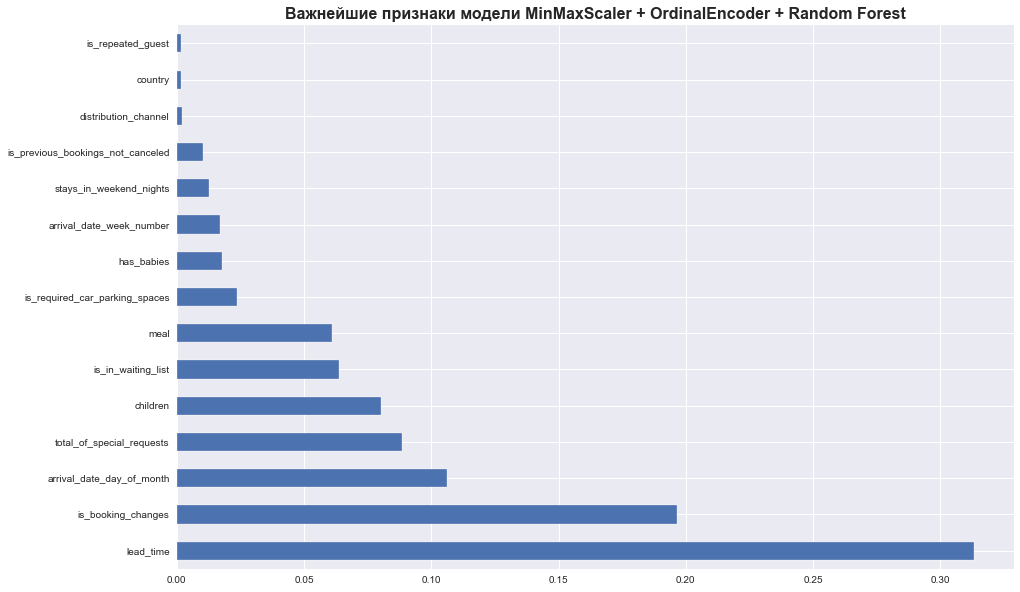

In [60]:
feature_importances = rs_imba.best_estimator_._final_estimator.feature_importances_

plt.figure(figsize=(15, 10))
pd.Series(feature_importances, features_test.columns).nlargest(15).plot(kind='barh')
plt.title('Важнейшие признаки модели MinMaxScaler + OrdinalEncoder + Random Forest', weight = 'bold')
plt.show()

Рассмотрим подробнее 7 наиболее значимых столбцов, чтобы выявить "портрет" клиента "склонного к отказу от брони.

Рассмотрим столбец `lead_time`.

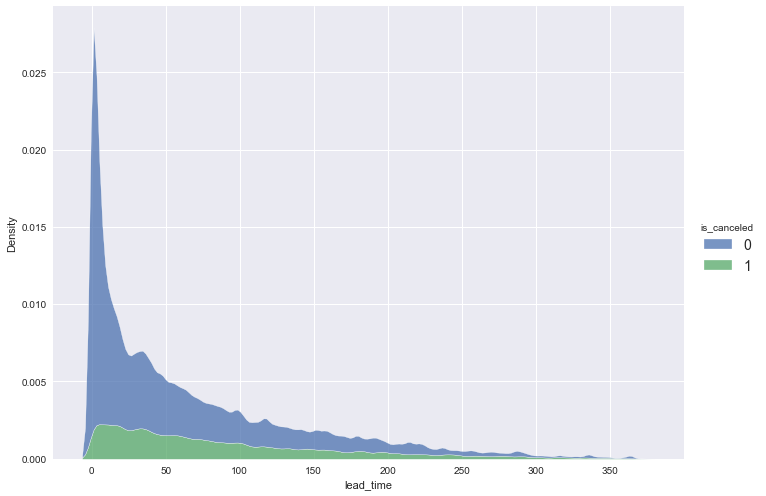

In [69]:
sns.displot(train, x='lead_time', hue='is_canceled', kind='kde', bw_adjust=.25, multiple='stack', height=7, aspect=7/5)
plt.show()

Исследуем колонку `is_previous_bookings_not_canceled`.

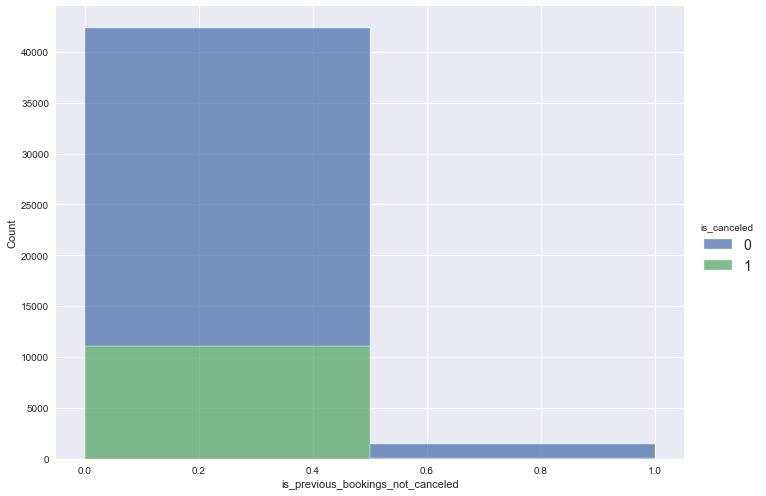

,is_canceled
is_previous_bookings_not_canceled,
0,0.2613
1,0.0546


In [70]:
sns.displot(train, x='is_previous_bookings_not_canceled', bins=2, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('is_previous_bookings_not_canceled')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Рассмотрим столбец `arrival_date_day_of_month`.

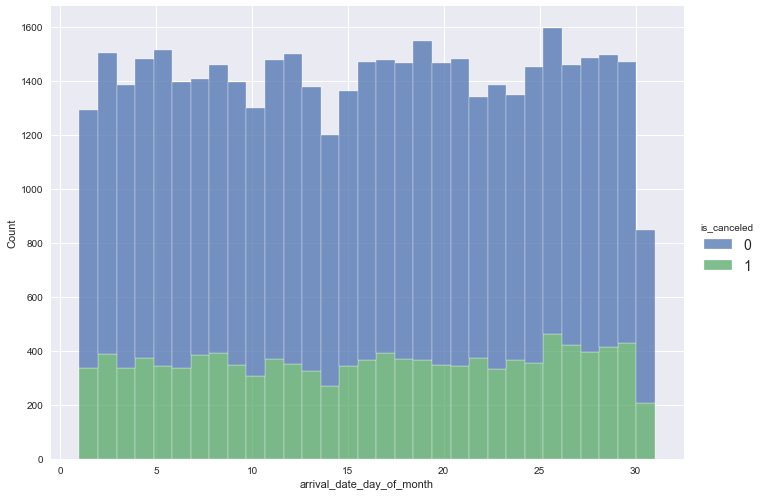

,is_canceled
arrival_date_day_of_month,
30,0.2922
26,0.2907
27,0.2894
22,0.2799
29,0.2774
7,0.2731
24,0.2708
28,0.2675
8,0.2675


In [71]:
sns.displot(train, x='arrival_date_day_of_month', bins=31, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('arrival_date_day_of_month')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Исследуем колонку `total_of_special_requests`.

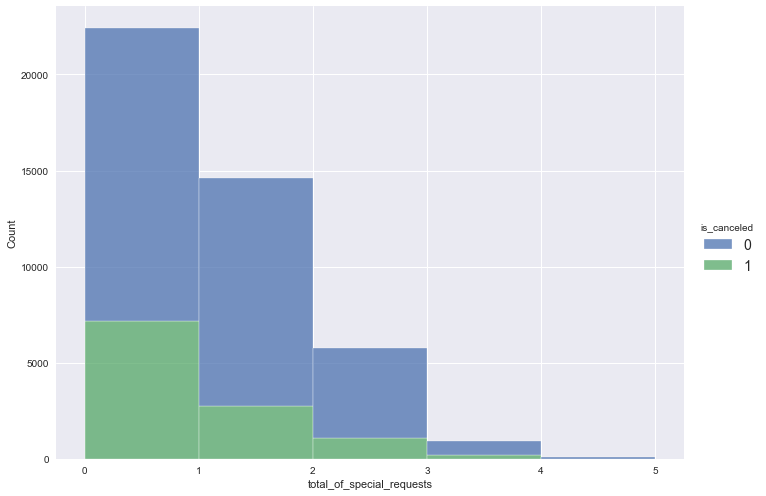

,is_canceled
total_of_special_requests,
0,0.3200
3,0.1904
1,0.1869
2,0.1831
4,0.1100
5,0.0000


In [72]:
sns.displot(train, x='total_of_special_requests', bins=5, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('total_of_special_requests')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Рассмотрим столбец `children`.

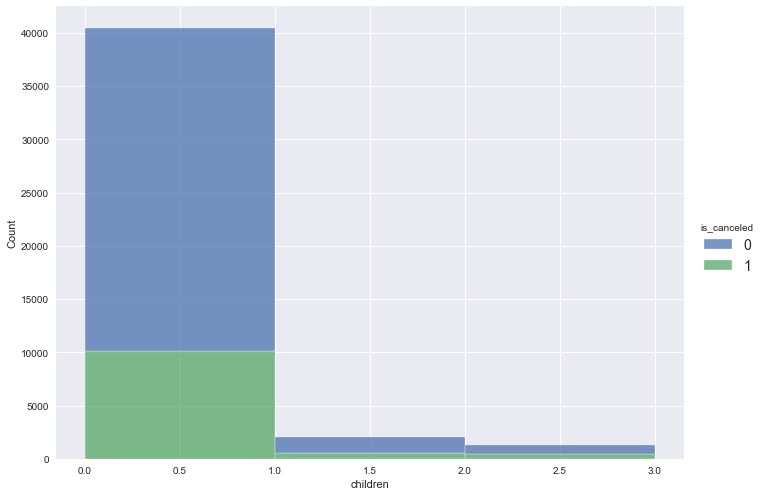

,is_canceled
children,
3,0.3750
2,0.3587
1,0.2728
0,0.2500


In [73]:
sns.displot(train, x='children', bins=3, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('children')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Исследуем колонку `is_in_waiting_list`.

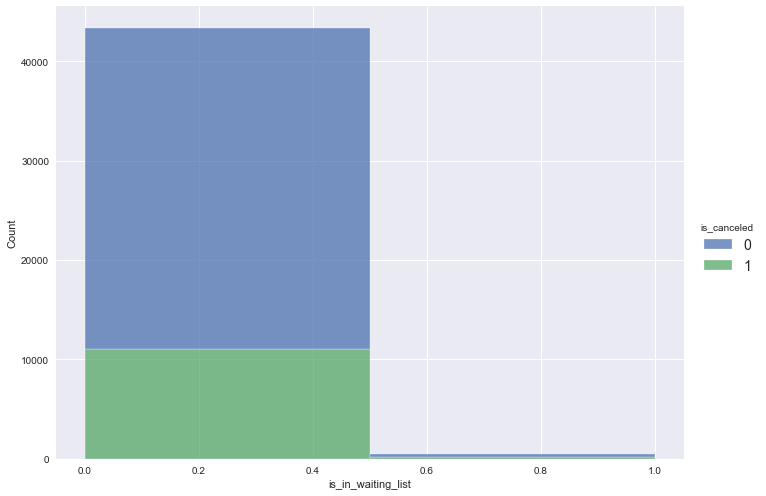

,is_canceled
is_in_waiting_list,
1,0.3146
0,0.2536


In [74]:
sns.displot(train, x='is_in_waiting_list', bins=2, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('is_in_waiting_list')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Исследуем колонку `meal`.

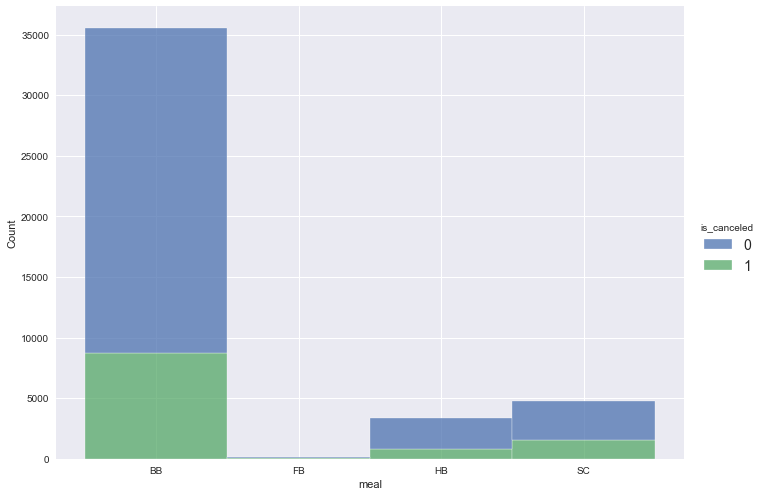

,is_canceled
meal,
SC,0.3248
FB,0.3037
BB,0.2454
HB,0.2452


In [75]:
sns.displot(train, x='meal', bins=4, hue='is_canceled', multiple='stack', height=7, aspect=7/5)
plt.show()
display(pd.DataFrame(train.groupby('meal')['is_canceled'].agg('mean')).sort_values('is_canceled', ascending=False))

Клиент, который сильно заранее забронировал номер, не отменявший до этого бронирование, с датой прибытия в конце месяца, не имеющий специальных отметок, имеющий детей, долго ожидал подтверждения и не заказал дополнительных опций, именно такой клиент, наиболее вероятно отменит бронирование.

## Общий вывод

В результате проведённого исследования, наилучшей моделью для предсказания отмены бронирования оказалась модель RandomForest, так как показала лучшую метрику полноты и скорость построения модели.
Расчётная модель показала хорошие характеристики, а с точки зрения бизнеса быстрые сроки окупаемости (менее одного месяца) и хорошую оценочную прибыльность.
С точки зрения бизнеса, если не использовать модель предсказания отказа от бронирования и не тратить на неё сил и средств, можно порекомендовать использовать депозиты для клиентов, которые бронируют номера задолго до заезда, с датой прибытия в конце месяца, не имеющие специальных отметок, имеющие детей, долго ожидающие подтверждения и не заказывающие дополнительных опций.
Однако, внедрение такой модели, окупит её в первый же месяц и принесёт расчётную прибыль *более 14.7 миллионов рублей за год*!